# Lecture 9: Class demo

### Imports

In [1]:
import os
import sys

sys.path.append(os.path.join(os.path.abspath(".."), (".."), "code"))

import IPython
import matplotlib.pyplot as plt
import mglearn
import numpy as np
import pandas as pd
from IPython.display import HTML, display
from plotting_functions import *
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler

%matplotlib inline

from IPython.display import Image
pd.set_option("display.max_colwidth", 200)
DATA_DIR = os.path.join(os.path.abspath(".."), (".."), "data/")

# Ignore future deprecation warnings from sklearn (using `os` instead of `warnings` also works in subprocesses)
import os
os.environ['PYTHONWARNINGS']='ignore::FutureWarning'

In [2]:
# Changing global matplotlib settings for confusion matrix.
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10

<br><br>

### Machine learning workflow 

- Here is a typical workflow of a supervised machine learning systems. 
- So far, we have talked about data splitting, preprocessing, some EDA, model selection with hyperparameter optimization, and interpretation in the context of linear models.
- In the next few lectures, we will talk about evaluation metrics and model selection in terms of evaluation metrics, feature engineering, feature selection, and model transparency and interpretation.  

![](../../img/ml-workflow.png)


<br><br><br><br>

## Evaluation metrics for binary classification: Motivation 

### Dataset for demonstration 

- Let's classify fraudulent and non-fraudulent transactions using Kaggle's [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) data set.
    - Note, that the credit card fraud detection data set is very large (150mb!) so we've stored it using [GitLFS](https://josh-ops.com/posts/add-files-to-git-lfs/) in a personal repo. You should download the data locally to follow-along, and be sure not to commit large data files to your repository!

In [3]:
# This dataset will be loaded using a URL instead of a CSV file
DATA_URL = "https://github.com/firasm/bits/raw/refs/heads/master/creditcard.csv"

cc_df = pd.read_csv(DATA_URL, encoding="latin-1")
# Sorting columns so it is easier to read
cc_df = cc_df[['Class', 'Time', 'Amount'] + cc_df.columns[cc_df.columns.str.startswith('V')].to_list()]

train_df, test_df = train_test_split(cc_df, test_size=0.3, random_state=111)

train_df

train_df, test_df = train_test_split(cc_df, test_size=0.3, random_state=111)
train_df.head()

,Class,Time,Amount,V1,V2,V3,V4,V5,V6,V7,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
64454,0,51150.0,1.00,-3.538816,3.481893,-1.827130,-0.573050,2.644106,-0.340988,2.102135,...,-1.509991,1.345904,0.530978,-0.860677,-0.201810,-1.719747,0.729143,-0.547993,-0.023636,-0.454966
37906,0,39163.0,18.49,-0.363913,0.853399,1.648195,1.118934,0.100882,0.423852,0.472790,...,0.810267,-0.192932,0.687055,-0.094586,0.121531,0.146830,-0.944092,-0.558564,-0.186814,-0.257103
79378,0,57994.0,23.74,1.193021,-0.136714,0.622612,0.780864,-0.823511,-0.706444,-0.206073,...,0.258815,-0.178761,-0.310405,-0.842028,0.085477,0.366005,0.254443,0.290002,-0.036764,0.015039
245686,0,152859.0,156.52,1.604032,-0.808208,-1.594982,0.200475,0.502985,0.832370,-0.034071,...,-1.009429,-0.040448,0.519029,1.429217,-0.139322,-1.293663,0.037785,0.061206,0.005387,-0.057296
60943,0,49575.0,57.50,-2.669614,-2.734385,0.662450,-0.059077,3.346850,-2.549682,-1.430571,...,0.157993,-0.430295,-0.228329,-0.370643,-0.211544,-0.300837,-1.174590,0.573818,0.388023,0.161782


In [4]:
train_df.shape

(199364, 31)

- Good size dataset 
- For confidentially reasons, it only provides transformed features with PCA, which is a popular dimensionality reduction technique. 

### EDA

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199364 entries, 64454 to 129900
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Class   199364 non-null  int64  
 1   Time    199364 non-null  float64
 2   Amount  199364 non-null  float64
 3   V1      199364 non-null  float64
 4   V2      199364 non-null  float64
 5   V3      199364 non-null  float64
 6   V4      199364 non-null  float64
 7   V5      199364 non-null  float64
 8   V6      199364 non-null  float64
 9   V7      199364 non-null  float64
 10  V8      199364 non-null  float64
 11  V9      199364 non-null  float64
 12  V10     199364 non-null  float64
 13  V11     199364 non-null  float64
 14  V12     199364 non-null  float64
 15  V13     199364 non-null  float64
 16  V14     199364 non-null  float64
 17  V15     199364 non-null  float64
 18  V16     199364 non-null  float64
 19  V17     199364 non-null  float64
 20  V18     199364 non-null  float64
 21  V19     199

In [6]:
train_df.describe(include="all")

,Class,Time,Amount,V1,V2,V3,V4,V5,V6,V7,...,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
count,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,...,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000,199364.000000
mean,0.001700,94888.815669,88.164679,0.000492,-0.000726,0.000927,0.000630,0.000036,0.000011,-0.001286,...,-0.001132,-0.001995,0.001205,0.000155,-0.000198,0.000113,0.000235,0.000312,-0.000366,0.000227
std,0.041201,47491.435489,238.925768,1.959870,1.645519,1.505335,1.413958,1.361718,1.327188,1.210001,...,0.814356,0.766957,0.748510,0.726634,0.628139,0.605060,0.520857,0.481960,0.401541,0.333139
min,0.000000,0.000000,0.000000,-56.407510,-72.715728,-31.813586,-5.683171,-42.147898,-26.160506,-43.557242,...,-4.932733,-28.009635,-34.830382,-8.887017,-44.807735,-2.824849,-10.295397,-2.241620,-22.565679,-11.710896
25%,0.000000,54240.000000,5.640000,-0.918124,-0.600193,-0.892476,-0.847178,-0.691241,-0.768512,-0.553979,...,-0.456984,-0.212688,-0.227836,-0.541795,-0.162330,-0.354604,-0.317761,-0.326730,-0.070929,-0.052819
50%,0.000000,84772.500000,22.000000,0.018854,0.065463,0.179080,-0.019531,-0.056703,-0.275290,0.040497,...,0.004125,-0.062702,-0.029146,0.007666,-0.011678,0.041031,0.016587,-0.052790,0.001239,0.011234
75%,0.000000,139349.250000,77.150000,1.315630,0.803617,1.028023,0.744201,0.610407,0.399827,0.570449,...,0.457170,0.132667,0.186899,0.529210,0.146809,0.439209,0.351366,0.242169,0.090453,0.078052
max,1.000000,172792.000000,11898.090000,2.451888,22.057729,9.382558,16.491217,34.801666,23.917837,44.054461,...,5.591971,24.133894,27.202839,10.503090,22.083545,4.022866,6.070850,3.517346,12.152401,33.847808


- We do not have categorical features. All features are numeric. 
- We have to be careful about the `Time` and `Amount` features. 
- We could scale `Amount`. 
- Do we want to scale time?
    - In this lecture, we'll just drop the Time feature. 
    - We'll learn about time series briefly later in the course. 

Let's separate `X` and `y` for train and test splits.

In [7]:
X_train_big, y_train_big = train_df.drop(columns=["Class", "Time"]), train_df["Class"]
X_test, y_test = test_df.drop(columns=["Class", "Time"]), test_df["Class"]

- It's easier to demonstrate evaluation metrics using an explicit validation set instead of using cross-validation. 
- So let's create a validation set. 
- Our data is large enough so it shouldn't be a problem. 


In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_big, y_train_big, test_size=0.3, random_state=123
)

### Baseline

In [9]:
dummy = DummyClassifier()
pd.DataFrame(cross_validate(dummy, X_train, y_train, return_train_score=True)).mean()

fit_time       0.007696
score_time     0.001194
test_score     0.998302
train_score    0.998302
dtype: float64

### Observations 

- `DummyClassifier` is getting 0.998 cross-validation accuracy!! 
- Should we be happy with this accuracy and deploy this `DummyClassifier` model for fraud detection? 

What's the class distribution? 

In [10]:
train_df["Class"].value_counts(normalize=True)

Class
0    0.9983
1    0.0017
Name: proportion, dtype: float64

- We have class imbalance. 
- We have MANY non-fraud transactions and only a handful of fraud transactions. 
- So in the training set, `most_frequent` strategy is labeling 199,025 (99.83%) instances correctly and only 339 (0.17%) instances incorrectly. 
- Is this what we want? 
- The "fraud" class is the important class that we want to spot. 

Let's scale the features and try `LogisticRegression`.   

In [11]:
pipe = make_pipeline(StandardScaler(), LogisticRegression())
pd.DataFrame(cross_validate(pipe, X_train, y_train, return_train_score=True)).mean()

fit_time       0.087506
score_time     0.004005
test_score     0.999183
train_score    0.999221
dtype: float64

- We are getting a slightly better score with logistic regression.  
- What score should be considered an acceptable score here? 
- Are we actually spotting any "fraud" transactions? 

- `.score` by default returns accuracy which is 
$$\frac{\text{correct predictions}}{\text{total examples}}$$
- Is accuracy a good metric here? 
- Is there anything more informative than accuracy that we can use here? 

Let's dig a little deeper.

<br><br><br><br>

## Thresholding 

- We have a logistic regression model for fraud detection that predicts a value between 0 and 1, representing the probability that a given email is spam.
- We use thresholding to get the binary prediction. 
- A typical threshold is 0.5.
    - A prediction of 0.90 $\rightarrow$ a high likelihood that the transaction is fraudulent and we predict **fraud**
    - A prediction of 0.20 $\rightarrow$ a low likelihood that the transaction is non-fraudulent and we predict **Non fraud**
- **What happens if the predicted score is equal to the chosen threshold?**

In [12]:
from IPython.display import HTML

# Create a link to the page
link = HTML("<a href='https://developers.google.com/machine-learning/crash-course/classification/thresholding' target='_blank'>Visit the Classification Thresholding Interactive Page</a>")
display(link)

## Confusion matrix

One way to get a better understanding of the errors is by looking at 
- false positives (type I errors), where the model incorrectly spots examples as fraud
- false negatives (type II errors), where it's missing to spot fraud examples 

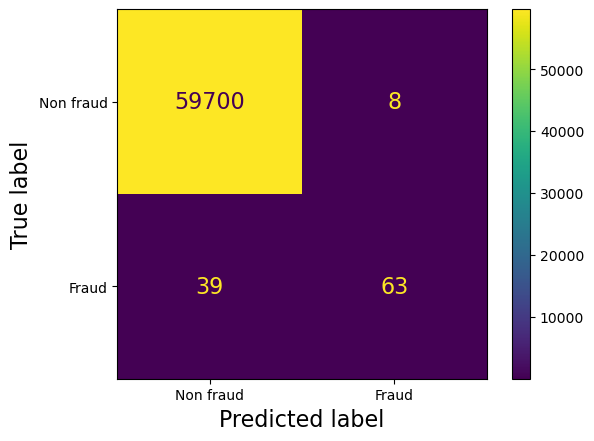

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay  

pipe.fit(X_train, y_train)
cm = ConfusionMatrixDisplay.from_estimator(
    pipe, X_valid, y_valid, values_format="d", display_labels=["Non fraud", "Fraud"]
)

### Which types of errors would be most critical for the bank to address?

<br><br><br><br>


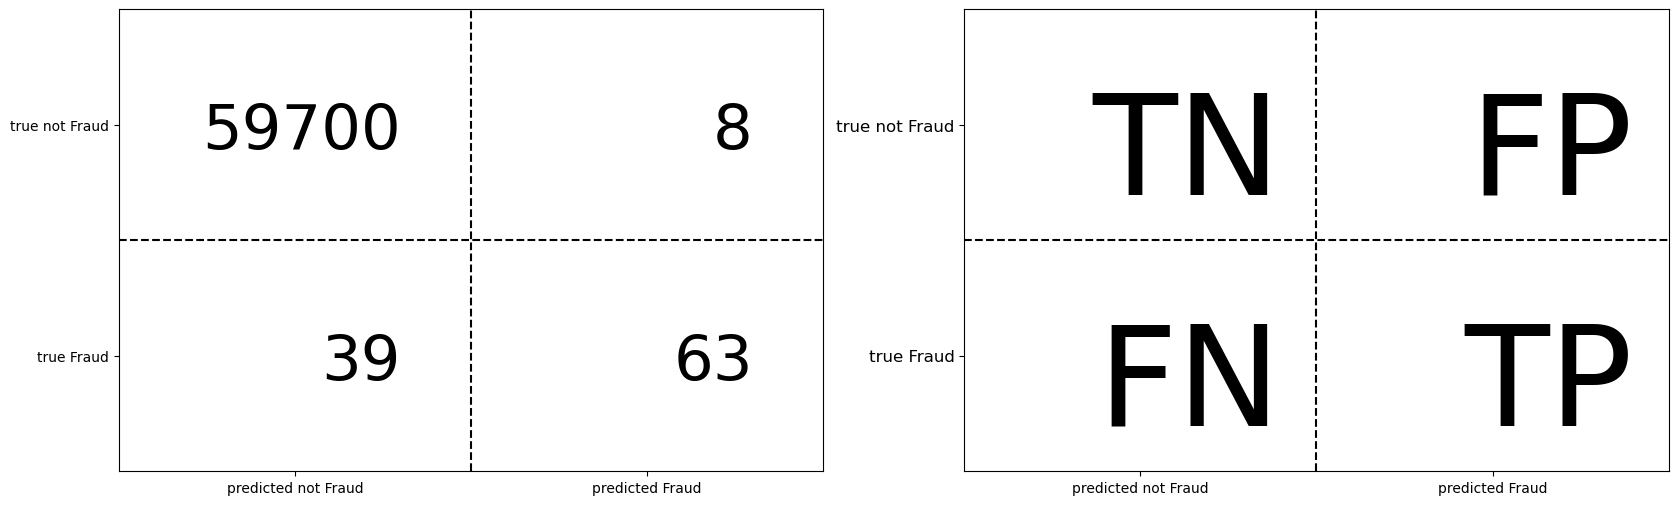

In [14]:
from sklearn.metrics import confusion_matrix

predictions = pipe.predict(X_valid)
TN, FP, FN, TP = confusion_matrix(y_valid, predictions).ravel()
plot_confusion_matrix_example(TN, FP, FN, TP)

- Perfect prediction has all values down the diagonal
- Off diagonal entries can often tell us about what is being mis-predicted

### What is "positive" and "negative"?

- Two kinds of binary classification problems 
    - Distinguishing between two classes
    - Spotting a class (spot fraud transaction, spot spam, spot disease)
- In case of spotting problems, the thing that we are interested in spotting is considered "positive". 
- Above we wanted to spot fraudulent transactions and so they are "positive". 

You can get a numpy array of confusion matrix as follows: 

In [15]:
from sklearn.metrics import confusion_matrix

predictions = pipe.predict(X_valid)
TN, FP, FN, TP = confusion_matrix(y_valid, predictions).ravel()
print("Confusion matrix for fraud data set")
print(cm.confusion_matrix)

Confusion matrix for fraud data set
[[59700     8]
 [   39    63]]


### Confusion matrix with cross-validation 

- You can also calculate confusion matrix with cross-validation using the `cross_val_predict` method.  
- But then you cannot plot it in a nice format. 

In [16]:
from sklearn.model_selection import cross_val_predict

confusion_matrix(y_train, cross_val_predict(pipe, X_train, y_train))

array([[139297,     20],
       [    94,    143]])

<br><br><br><br>

## Precision, recall, f1 score 

- We have been using `.score` to assess our models, which returns accuracy by default. 
- Accuracy is misleading when we have class imbalance.
- We need other metrics to assess our models.

- We'll discuss three commonly used metrics which are based on confusion matrix: 
    - recall
    - precision
    - f1 score 
- Note that these metrics will only help us assess our model.  
- Later we'll talk about a few ways to address class imbalance problem. 

### Precision and recall: toy example
- Imagine that your model has identified everything outside the circle as non-fraud and everything inside the circle as fraud. 

![](../../img/precision-recall.png)

![](../../img/fraud-precision-recall.png)

In [17]:
from sklearn.metrics import confusion_matrix

pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
pipe_lr.fit(X_train, y_train)
predictions = pipe_lr.predict(X_valid)
TN, FP, FN, TP = confusion_matrix(y_valid, predictions).ravel()
print(cm.confusion_matrix)

[[59700     8]
 [   39    63]]


### Precision 

Among the positive examples you identified, how many were actually positive?

$$ precision = \frac{TP}{TP+FP}$$

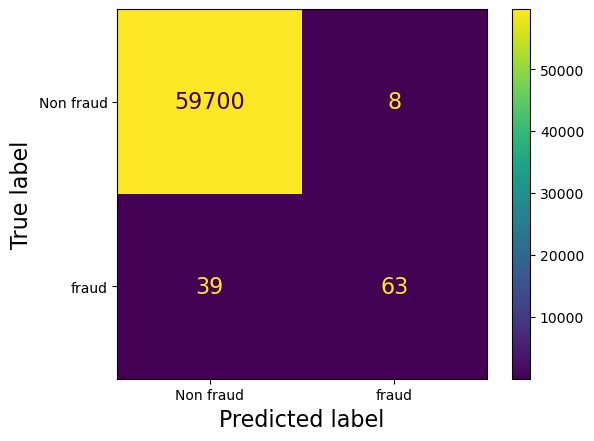

In [18]:
cm = ConfusionMatrixDisplay.from_estimator(
    pipe, X_valid, y_valid, values_format="d", display_labels=["Non fraud", "fraud"]
);

In [19]:
print("TP = %0.4f, FP = %0.4f" % (TP, FP))
precision = TP / (TP + FP)
print("Precision: %0.4f" % (precision))

TP = 63.0000, FP = 8.0000
Precision: 0.8873


### Recall 

Among all positive examples, how many did you identify correctly?
$$ recall = \frac{TP}{TP+FN} = \frac{TP}{\#positives} $$

- Also called as sensitivity, coverage, true positive rate (TPR)

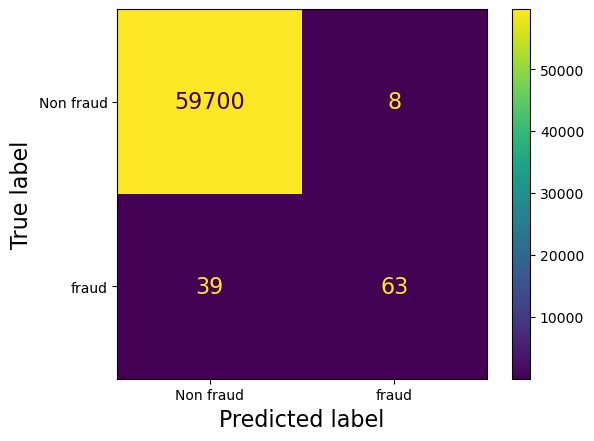

In [20]:
ConfusionMatrixDisplay.from_estimator(
    pipe, X_valid, y_valid, values_format="d", display_labels=["Non fraud", "fraud"]
);

In [21]:
print("TP = %0.4f, FN = %0.4f" % (TP, FN))
recall = TP / (TP + FN)
print("Recall: %0.4f" % (recall))

TP = 63.0000, FN = 39.0000
Recall: 0.6176


### F1-score

- F1-score combines precision and recall to give one score, which could be used in hyperparameter optimization, for instance. 
- F1-score is a harmonic mean of precision and recall. 


$$ f1 = 2 \times \frac{ precision \times recall}{precision + recall}$$


In [22]:
print("precision: %0.4f" % (precision))
print("recall: %0.4f" % (recall))
f1_score = (2 * precision * recall) / (precision + recall)
print("f1: %0.4f" % (f1_score))

precision: 0.8873
recall: 0.6176
f1: 0.7283


Let's look at all metrics at once on our dataset.

In [23]:
## Calculate evaluation metrics by ourselves
data = {
    "calculation": [],
    "accuracy": [],
    "error": [],
    "precision": [],
    "recall": [],
    "f1 score": [],
}
data["calculation"].append("manual")
data["accuracy"].append((TP + TN) / (TN + FP + FN + TP))
data["error"].append((FP + FN) / (TN + FP + FN + TP))
data["precision"].append(precision)  # TP / (TP + FP)
data["recall"].append(recall)  # TP / (TP + FN)
data["f1 score"].append(f1_score)  # (2 * precision * recall) / (precision + recall)
df = pd.DataFrame(data)
df

,calculation,accuracy,error,precision,recall,f1 score
0,manual,0.999214,0.000786,0.887324,0.617647,0.728324


- `scikit-learn` has functions for [these metrics](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics).

In [24]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

data["accuracy"].append(accuracy_score(y_valid, pipe_lr.predict(X_valid)))
data["error"].append(1 - accuracy_score(y_valid, pipe_lr.predict(X_valid)))
data["precision"].append(
    precision_score(y_valid, pipe_lr.predict(X_valid), zero_division=1)
)
data["recall"].append(recall_score(y_valid, pipe_lr.predict(X_valid)))
data["f1 score"].append(f1_score(y_valid, pipe_lr.predict(X_valid)))
data["calculation"].append("sklearn")
df = pd.DataFrame(data)
df.set_index(["calculation"])

,accuracy,error,precision,recall,f1 score
calculation,,,,,
manual,0.999214,0.000786,0.887324,0.617647,0.728324
sklearn,0.999214,0.000786,0.887324,0.617647,0.728324


The scores match. 

### Classification report 

- There is a convenient function called `classification_report` in `sklearn` which gives this info. 

In [25]:
pipe_lr.classes_

array([0, 1])

In [26]:
from sklearn.metrics import classification_report

print(
    classification_report(
        y_valid, pipe_lr.predict(X_valid), target_names=["non-fraud", "fraud"]
    )
)

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.89      0.62      0.73       102

    accuracy                           1.00     59810
   macro avg       0.94      0.81      0.86     59810
weighted avg       1.00      1.00      1.00     59810



<br><br>

### Interim summary 

- Accuracy is misleading when you have class imbalance. 
- A confusion matrix provides a way to break down errors made by our model. 
- We looked at three metrics based on confusion matrix: 
    - precision, recall, f1-score. 

- Note that what you consider "positive" (fraud in our case) is important when calculating precision, recall, and f1-score. 
- If you flip what is considered positive or negative, we'll end up with different TP, FP, TN, FN, and hence different precision, recall, and f1-scores. 

### Evalution metrics overview  
There is a lot of terminology here. 

![](../../img/evaluation-metrics.png)

### Cross validation with different metrics

- We can pass different evaluation metrics with `scoring` argument of `cross_validate`.

In [27]:
scoring = [
    "accuracy",
    "f1",
    "recall",
    "precision",
]  # scoring can be a string, a list, or a dictionary
pipe = make_pipeline(StandardScaler(), LogisticRegression())
scores = cross_validate(
    pipe, X_train_big, y_train_big, return_train_score=True, scoring=scoring
)
pd.DataFrame(scores)

,fit_time,score_time,test_accuracy,train_accuracy,test_f1,train_f1,test_recall,train_recall,test_precision,train_precision
0,0.130784,0.019137,0.999122,0.999335,0.700855,0.772532,0.602941,0.664207,0.836735,0.923077
1,0.128030,0.019790,0.999223,0.999317,0.735043,0.765591,0.632353,0.656827,0.877551,0.917526
2,0.142498,0.020001,0.999298,0.999210,0.754386,0.724891,0.632353,0.612546,0.934783,0.887701
3,0.133692,0.018641,0.999172,0.999254,0.697248,0.742981,0.558824,0.634686,0.926829,0.895833
4,0.127933,0.018166,0.999147,0.999185,0.696429,0.716157,0.582090,0.602941,0.866667,0.881720


- You can also create [your own scoring function](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html) and pass it to `cross_validate`. 

<br><br>

## Precision-recall curve

- Confusion matrix provides a detailed break down of the errors made by the model. 
- But when creating a confusion matrix, we are using "hard" predictions. 
- Most classifiers in `scikit-learn` provide `predict_proba` method (or `decision_function`) which provides degree of certainty about predictions by the classifier. 
- Can we explore the degree of uncertainty to understand and improve the model performance? 

Let's revisit the classification report on our fraud detection example. 

In [28]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression())
pipe_lr.fit(X_train, y_train);

In [29]:
y_pred = pipe_lr.predict(X_valid)
print(classification_report(y_valid, y_pred, target_names=["non-fraud", "fraud"]))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.89      0.62      0.73       102

    accuracy                           1.00     59810
   macro avg       0.94      0.81      0.86     59810
weighted avg       1.00      1.00      1.00     59810



By default, predictions use the threshold of 0.5. If `predict_proba` > 0.5, predict "fraud" else predict "non-fraud".

In [30]:
y_pred = pipe_lr.predict_proba(X_valid)[:, 1] > 0.50
print(classification_report(y_valid, y_pred, target_names=["non-fraud", "fraud"]))

              precision    recall  f1-score   support

   non-fraud       1.00      1.00      1.00     59708
       fraud       0.89      0.62      0.73       102

    accuracy                           1.00     59810
   macro avg       0.94      0.81      0.86     59810
weighted avg       1.00      1.00      1.00     59810



- Suppose for your business it is more costly to miss fraudulent transactions and suppose you want to achieve a recall of at least 75% for the "fraud" class. 
- One way to do this is by changing the threshold of `predict_proba`.
    - `predict` returns 1 when `predict_proba`'s probabilities are above 0.5 for the "fraud" class.

**Key idea: what if we threshold the probability at a smaller value so that we identify more examples as "fraud" examples?** 

Let's lower the threshold to 0.1. In other words, predict the examples as "fraud" if `predict_proba` > 0.1.  

In [31]:
y_pred_lower_threshold = pipe_lr.predict_proba(X_valid)[:, 1] > 0.1

In [32]:
print(classification_report(y_valid, y_pred_lower_threshold))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     59708
           1       0.77      0.75      0.76       102

    accuracy                           1.00     59810
   macro avg       0.88      0.88      0.88     59810
weighted avg       1.00      1.00      1.00     59810



### Operating point 

- Now our recall for "fraud" class is >= 0.75. 
- Setting a requirement on a classifier (e.g., recall of >= 0.75) is called setting the **operating point**. 
- It's usually driven by business goals and is useful to make performance guarantees to customers. 

### Precision/Recall tradeoff 

- But there is a trade-off between precision and recall. 
- If you identify more things as "fraud", recall is going to increase but there are likely to be more false positives. 

Let's sweep through different thresholds. 

In [33]:
thresholds = np.arange(0.0, 1.0, 0.1)
thresholds

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

You need to install `panel` package in order to run the code below locally. See the documentation [here](https://pyviz-dev.github.io/panel/getting_started/installation.html#jupyterlab-and-classic-notebook). 

```conda install -c pyviz panel```

In [34]:
import panel as pn
from panel import widgets
from panel.interact import interact

pn.extension()

def f(threshold):
    preds = pipe_lr.predict_proba(X_valid)[:, 1] > threshold
    precision = np.round(precision_score(y_valid, preds), 4)
    recall = np.round(recall_score(y_valid, preds), 4)
    d = {'threshold':np.round(threshold, 4), 'Precision': precision, 'recall': recall}
    return (d)

interact(f, threshold=widgets.FloatSlider(start=0.0, end=0.99, step=0.05, value=0.5)).embed(max_opts=20)

### Decreasing the threshold

- Decreasing the threshold means a lower bar for predicting fraud. 
    - You are willing to risk more false positives in exchange of more true positives. 
    - Recall would either stay the same or go up and precision is likely to go down
    - Occasionally, precision may increase if all the new examples after decreasing the threshold are TPs. 

### Increasing the threshold

- Increasing the threshold means a higher bar for predicting fraud. 
    - Recall would go down or stay the same but precision is likely to go up 
    - Occasionally, precision may go down if TP decrease but FP do not decrease.

### Precision-recall curve

Often, when developing a model, it's not always clear what the operating point will be and to understand the model better, it's informative to look at all possible thresholds and corresponding trade-offs of precision and recall in a plot.  


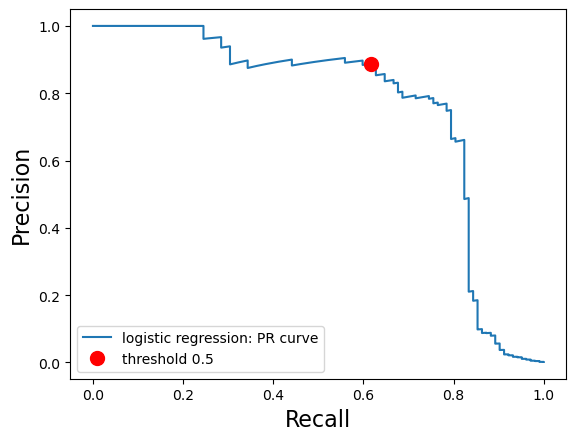

In [35]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_valid, pipe_lr.predict_proba(X_valid)[:, 1]
)
plt.plot(recall, precision, label="logistic regression: PR curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot(
    recall_score(y_valid, pipe_lr.predict(X_valid)),
    precision_score(y_valid, pipe_lr.predict(X_valid)),    
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best", fontsize=10);

- Each point in the curve corresponds to a possible threshold of the `predict_proba` output. 
- We can achieve a recall of 0.8 at a precision of 0.4. 
- The red dot marks the point corresponding to the threshold 0.5.
- The top-right would be a perfect classifier (precision = recall = 1).

- The threshold is not shown here, but it's going from 0 (upper-left) to 1 (lower right).
- At a threshold of 0 (upper left), we are classifying everything  as "fraud".
- Raising the threshold increases the precision but at the expense of lowering the recall. 
- At the extreme right, where the threshold is 1, we get into the situation where all the examples classified as "fraud" are actually "fraud"; we have no false positives. 
- Here we have a high precision but lower recall. 
- Usually the goal is to keep recall high as precision goes up. 

### AP score 

- Often it's useful to have one number summarizing the PR plot (e.g., in hyperparameter optimization)
- One way to do this is by computing the area under the PR curve. 
- This is called **average precision** (AP score)
- AP score has a value between 0 (worst) and 1 (best). 

In [36]:
from sklearn.metrics import average_precision_score

ap_lr = average_precision_score(y_valid, pipe_lr.predict_proba(X_valid)[:, 1])
print("Average precision of logistic regression: {:.3f}".format(ap_lr))

Average precision of logistic regression: 0.757


You can also use the following handy function of `sklearn` to get the PR curve and the corresponding AP score. 

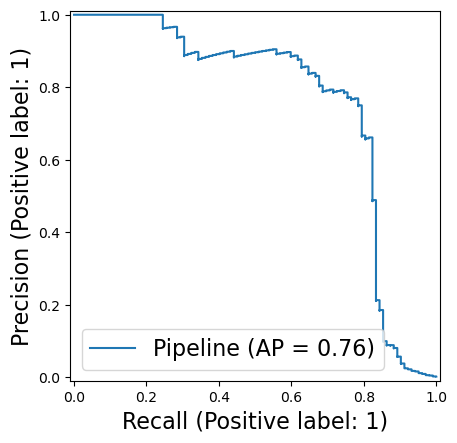

In [37]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(pipe_lr, X_valid, y_valid);

### AP vs. F1-score

It is very important to note this distinction:

- F1 score is for a given threshold and measures the quality of `predict`.
- AP score is a summary across thresholds and measures the quality of `predict_proba`.


```{important}
Remember to pick the desired threshold based on the results on the validation set and **not** on the test set.
```

### A few comments on PR curve

- Different classifiers might work well in different parts of the curve, i.e., at different operating points.   
- We can compare PR curves of different classifiers to understand these differences. 
- Let's create PR curves for SVC and Logistic Regression. 

In [38]:
pipe_svc = make_pipeline(StandardScaler(), SVC())

pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [39]:
pipe_lr = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))
pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

How to get precision and recall for different thresholds? 
- Use the function `precision_recall_curve`

In [40]:
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(
    y_valid, pipe_lr.predict_proba(X_valid)[:, 1]
)

### (Optional) Some more details

- How are the thresholds and the precision and recall at the default threshold are calculated? 

How many thresholds? 
- It uses `n_thresholds` where `n_thresholds` is the number of unique `predict_proba` scores in our dataset. 

In [41]:
len(np.unique(pipe_lr.predict_proba(X_valid)[:, 1]))

59049

- For each threshold, precision and recall are calculated.  
- The last precision and recall values are 1. and 0. respectively and do not have a corresponding threshold. 

In [42]:
thresholds_lr.shape, precision_lr.shape, recall_lr.shape

((59049,), (59050,), (59050,))

In [43]:
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(
    y_valid, pipe_lr.predict_proba(X_valid)[:, 1]
)
precision_svc, recall_svc, thresholds_svc = precision_recall_curve(
    y_valid, pipe_svc.decision_function(X_valid)
)

For logistic regression, what's the index of the threshold that is closest to the default threshold of 0.5? 
- We are subtracting 0.5 from the thresholds so that 
    - the numbers close to 0 become -0.5
    - the numbers close to 1 become 0.5    
    - the numbers close to 0.5 become 0
- After this transformation, we are interested in the threshold index where the number is close to 0. So we take  absolute values and argmin.       

In [44]:
close_default_lr = np.argmin(np.abs(thresholds_lr - 0.5))

SVC doesn't have `predict_proba`. Instead it has something called `decision_function`. The index of the threshold that is closest to 0 of decision function is the default threshold in SVC. 

In [45]:
close_default_lr = np.argmin(np.abs(thresholds_lr - 0.5))
close_zero_svm = np.argmin(np.abs(thresholds_svc))

### PR curves for logistic regression and SVC

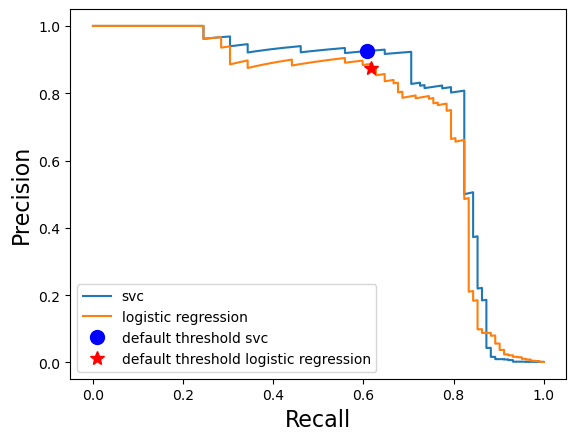

In [46]:
plt.plot(recall_svc, precision_svc, label="svc")
plt.plot(recall_lr, precision_lr, label="logistic regression")
plt.plot(
    recall_svc[close_zero_svm],
    precision_svc[close_zero_svm],    
    "o",
    markersize=10,
    label="default threshold svc",
    c="b",
)
plt.plot(
    recall_lr[close_default_lr],
    precision_lr[close_default_lr],    
    "*",
    markersize=10,
    label="default threshold logistic regression",
    c="r",
)

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend(loc="best", fontsize=10);

#### Which model is doing better in this scenario: SVC or Logistic Regression? 

<br><br><br><br>

In [47]:
svc_preds = pipe_svc.predict(X_valid)
lr_preds = pipe_lr.predict(X_valid)

In [48]:
print("f1_score of logistic regression: {:.3f}".format(f1_score(y_valid, lr_preds)))
print("f1_score of svc: {:.3f}".format(f1_score(y_valid, svc_preds)))

f1_score of logistic regression: 0.728
f1_score of svc: 0.726


In [49]:
ap_lr = average_precision_score(y_valid, pipe_lr.predict_proba(X_valid)[:, 1])
ap_svc = average_precision_score(y_valid, pipe_svc.decision_function(X_valid))

In [50]:
print("Average precision of logistic regression: {:.3f}".format(ap_lr))
print("Average precision of SVC: {:.3f}".format(ap_svc))

Average precision of logistic regression: 0.757
Average precision of SVC: 0.790


- Comparing the precision-recall curves provide us a detail insight compared to f1 score.
- For example, F1 scores for SVC and logistic regressions are pretty similar. In fact, f1 score of logistic regression is a tiny bit better. 
- But when we look at the PR curve, we see that SVC is doing better than logistic regression for most of the other thresholds. 

<br><br><br><br>

## Receiver Operating Characteristic (ROC) curve 

- Another commonly used tool to analyze the behavior of classifiers at different thresholds.  
- Similar to PR curve, it considers all possible thresholds for a given classifier given by `predict_proba` but instead of precision and recall it plots false positive rate (FPR) and true positive rate (TPR or recall).
$$ TPR = \frac{TP}{TP + FN}$$

$$ FPR  = \frac{FP}{FP + TN}$$

- TPR $\rightarrow$ Fraction of true positives out of all positive examples. 
- FPR $\rightarrow$ Fraction of false positives out of all negative examples. 


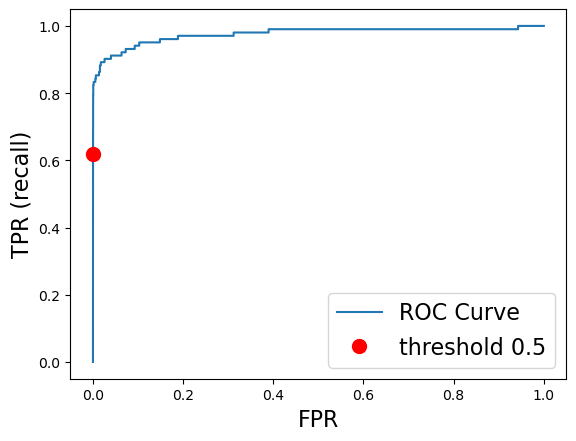

In [51]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_valid, pipe_lr.predict_proba(X_valid)[:, 1])
plt.plot(fpr, tpr, label="ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR (recall)")

default_threshold = np.argmin(np.abs(thresholds - 0.5))

plt.plot(
    fpr[default_threshold],
    tpr[default_threshold],
    "or",
    markersize=10,
    label="threshold 0.5",
)
plt.legend(loc="best");

- Different points on the ROC curve represent different classification thresholds. The curve starts at (0,0) and ends at (1, 1).
    - (0, 0) represents the threshold that classifies everything as the negative class
    - (1, 1) represents the threshold that classifies everything as the positive class 
- The ideal curve is close to the top left
    - Ideally, you want a classifier with high recall while keeping low false positive rate.  
- The red dot corresponds to the threshold of 0.5, which is used by predict.
- We see that compared to the default threshold, we can achieve a better recall of around 0.8 without increasing FPR. 

Let's compare ROC curve of different classifiers. 

In [52]:
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_valid, pipe_lr.predict_proba(X_valid)[:, 1])

fpr_svc, tpr_svc, thresholds_svc = roc_curve(
    y_valid, pipe_svc.decision_function(X_valid)
)

In [53]:
close_default_lr = np.argmin(np.abs(thresholds_lr - 0.5))
close_zero_svm = np.argmin(np.abs(thresholds_svc))

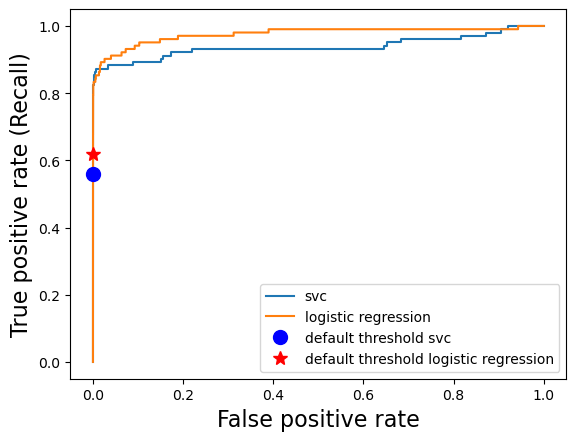

In [54]:
plt.plot(fpr_svc, tpr_svc, label="svc")
plt.plot(fpr_lr, tpr_lr, label="logistic regression")
plt.plot(
    fpr_svc[close_zero_svm],
    tpr_svc[close_zero_svm],
    "o",
    markersize=10,
    label="default threshold svc",
    c="b",
)
plt.plot(
    fpr_lr[close_default_lr],
    tpr_lr[close_default_lr],
    "*",
    markersize=10,
    label="default threshold logistic regression",
    c="r",
)

plt.xlabel("False positive rate")
plt.ylabel("True positive rate (Recall)")
plt.legend(loc="best", fontsize=10);

### Area under the curve (AUC)

- AUC provides a single meaningful number for the model performance. 

In [55]:
from sklearn.metrics import roc_auc_score

roc_lr = roc_auc_score(y_valid, pipe_lr.predict_proba(X_valid)[:, 1])
roc_svc = roc_auc_score(y_valid, pipe_svc.decision_function(X_valid))
print("AUC for LR: {:.3f}".format(roc_lr))
print("AUC for SVC: {:.3f}".format(roc_svc))

AUC for LR: 0.976
AUC for SVC: 0.938


- AUC of 0.5 means random chance. 
- AUC can be interpreted as evaluating the **ranking** of positive examples.
- What's the probability that a randomly picked positive point has a higher score according to the classifier than a randomly picked point from the negative class. 
- AUC of 1.0 means all positive points have a higher score than all negative points. 

```{important}
For classification problems with imbalanced classes, using AP score or AUC is often much more meaningful than using accuracy. 
```

Similar to `PrecisionRecallCurveDisplay`, there is a `RocCurveDisplay` function in sklearn. 

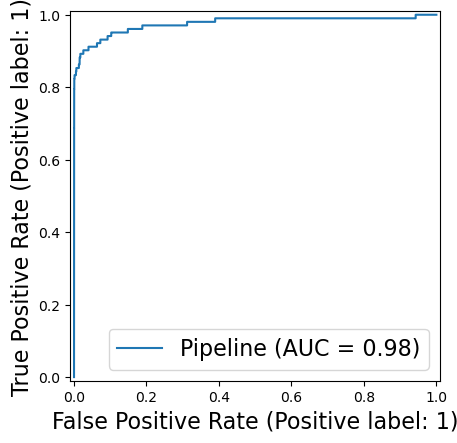

In [56]:
from sklearn.metrics import RocCurveDisplay

RocCurveDisplay.from_estimator(pipe_lr, X_valid, y_valid);

### Let's look at all the scores at once

In [57]:
scoring = ["accuracy", "f1", "recall", "precision", "roc_auc", "average_precision"]
pipe = make_pipeline(StandardScaler(), LogisticRegression())
scores = cross_validate(pipe, X_train_big, y_train_big, scoring=scoring)
pd.DataFrame(scores).mean()

fit_time                  0.143763
score_time                0.032660
test_accuracy             0.999192
test_f1                   0.716792
test_recall               0.601712
test_precision            0.888513
test_roc_auc              0.967907
test_average_precision    0.743135
dtype: float64

```{seealso}
Check out [these visualization](https://github.com/dariyasydykova/open_projects/tree/master/ROC_animation) on ROC and AUC.  
```

```{seealso}
Check out how to plot ROC with cross-validation [here](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html).
```

<br><br><br><br>